In [1]:
import numpy as np
from sqlalchemy import create_engine, text
import pandas as pd
import requests
import yaml
import ast
import json
import numpy as np
import scipy as sp
import copy
import os 
import pathlib
import sys
import requests
import io
import time
import matplotlib.pyplot as plt
import re

%matplotlib inline

In [2]:
# repo_path="/home/ecosang/repos/hpflex_mpc/" 
# all code is based on path /hpflex_mpc/
# repo_path=pathlib.Path(os.getcwd()).parents[2].absolute().__str__()
# sys.path.insert(1,pathlib.Path(repo_path).absolute().__str__()) # repository path
# os.chdir(pathlib.Path(repo_path).absolute().__str__())

In [3]:
from datetime import datetime
import pytz
tz="US/Pacific"#metadata['tz']

In [4]:
# it may take time to download ~30MB csv. (a few mins or less)
df=pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vQuEj3KDo6WwCPK-YW40yS8S-cz6H3eQx3GwgqJB2dfZ5KSEVAbTP0sPtjGlt2kcfCfZMD04UZT-HvB/pub?gid=1052501758&single=true&output=csv",index_col=0)

In [5]:
df['i_heat_1']=df['i_heat_1_0'].to_numpy()+df['i_heat_1_1'].to_numpy() # two stages to single number

In [6]:
df['P_all_1']=df['P_hp_1'].to_numpy()+df['Q_gain_1'].to_numpy() # HP power + Plugload = BLDG power (P_all)

In [7]:
def add_mpc_inputs(df_):
    forecast_hours=24
    hsp_o=70  # 21.11 # baseline schedule
    hsp_uo=60 # 15.56

    csp_o=74 # baseline cooling setpoint
    csp_uo=80

    o_start=6 #from  occupancy schedule
    o_end=17  #till 20pm
    
    # one day hours
    one_day_hours=np.arange(24)    
    # one_day_hours=np.array((pd.Timestamp(current_time_local,tz="US/Pacific")+pd.timedelta_range(start='0 H', periods=forecast_hours,freq='1H')).strftime("%H")).astype('int')
    uo_idx=(one_day_hours<o_start)|(one_day_hours>o_end)
    o_idx=~uo_idx
    #hour_vec
    Thsp_base=np.zeros(forecast_hours)+(hsp_uo-32)/1.8
    Tcsp_base=np.zeros(forecast_hours)+(csp_uo-32)/1.8
    Thsp_base[o_idx]=(hsp_o-32)/1.8
    Tcsp_base[o_idx]=(csp_o-32)/1.8
    # Electricity rate
    ER_evening=np.array([0.264,0.241,0.220,0.221,0.238,0.378,0.700,0.466,0.351,0.297,0.264,0.241,0.220,0.221,0.238,0.292,0.378,0.592,0.690,0.700,0.629,0.541,0.445,0.405])

    hour_vec=df_['hour'].to_numpy().astype('int')#.astype('int')  #np.array((pd.Timestamp(current_time_local,tz="US/Pacific")+pd.timedelta_range(start='0 H', periods=forecast_hours*(3600/Ts),freq=pd.Timedelta(f"{Ts}sec"))).strftime("%H")).astype('int')
    Tcsp=Tcsp_base[hour_vec]
    Thsp=Thsp_base[hour_vec]
    prices=ER_evening[hour_vec]
    hvac_occ=(o_idx*1)[hour_vec]
    df_['Thsp']=Thsp
    df_['Tcsp']=Tcsp
    df_['price']=prices
    return df_

In [8]:
df.columns

Index(['timestamp_utc', 'ghi_1', 'syscontrol_1', 'V_ra_1', 'V_sa_1',
       'spd_fan_1', 'pi_cool_1', 'pi_heat_1', 'T_za_1', 'i_hc_0_1', 'i_hc_1_1',
       'T_sa_1', 'sysmode_1', 'T_zap_0_1', 'T_zap_1_1', 'T_slab_0_1',
       'T_slab_1_1', 'T_oa_1', 'Q_occupancy_1', 'Q_plug_1', 'Q_light_1',
       'Q_gain_1', 'i_heat_1_0', 'i_cool_1_0', 'i_heat_1_1', 'i_cool_1_1',
       'P_hp_1', 'timestamp_local', 'time', 'hour', 'day', 'month', 'mday',
       'i_heat_1', 'P_all_1', 'Thsp', 'Tcsp', 'price', 'ma_i_heat_1',
       'ma_P_hp_1', 'ma_P_all_1', 'ma_T_za_1', 'mpc_hybrid', 'mpc_ideal',
       'baseline', 'peak', 'ma_T_za_1_F', 'ThspF', 'elec', 'hour_int',
       'group_id'],
      dtype='object')

In [9]:
df=add_mpc_inputs(df) # add mpc-related inputs, ER signal, setpoints, etc.

In [10]:
df

,timestamp_utc,ghi_1,syscontrol_1,V_ra_1,V_sa_1,spd_fan_1,pi_cool_1,pi_heat_1,T_za_1,i_hc_0_1,...,ma_T_za_1,mpc_hybrid,mpc_ideal,baseline,peak,ma_T_za_1_F,ThspF,elec,hour_int,group_id
0,2022-04-15 07:00:00+00:00,0.000544,1.0,0.317290,0.438817,85,0.0,0,17.055556,0,...,17.061111,0,0,0,0,62.600000,60,0.001300,0,415
1,2022-04-15 07:01:00+00:00,0.000650,1.0,0.317196,0.438014,85,0.0,0,17.055556,0,...,17.062724,0,0,0,0,62.588889,60,0.001300,0,415
2,2022-04-15 07:02:00+00:00,0.000591,1.0,0.315780,0.437826,85,0.0,0,17.055556,0,...,17.060764,0,0,0,0,62.580000,60,0.001299,0,415
3,2022-04-15 07:03:00+00:00,0.000540,1.0,0.317337,0.435277,85,0.0,0,17.055556,0,...,17.055556,0,0,0,0,62.572727,60,0.001299,0,415
4,2022-04-15 07:04:00+00:00,0.000453,1.0,0.317904,0.434286,85,0.0,0,16.944444,0,...,17.052288,0,0,0,0,62.575000,60,0.001299,0,415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48955,2022-05-19 06:55:00+00:00,0.000412,1.0,0.000000,0.000000,0,0.0,0,22.111111,0,...,22.090476,0,1,0,0,71.800000,60,0.000410,23,519
48956,2022-05-19 06:56:00+00:00,0.000580,1.0,0.000000,0.000000,0,0.0,0,22.111111,0,...,22.091503,0,1,0,0,71.800000,60,0.000409,23,519
48957,2022-05-19 06:57:00+00:00,0.000595,1.0,0.000000,0.000000,0,0.0,0,22.111111,0,...,22.092593,0,1,0,0,71.800000,60,0.000409,23,519
48958,2022-05-19 06:58:00+00:00,0.001255,1.0,0.000000,0.000000,0,0.0,0,22.111111,0,...,22.093750,0,1,0,0,71.800000,60,0.000409,23,519


In [11]:
# days 419: 4/19 
mpc_ideal_days=np.array([419,420,421,424,502,505,506,510,512,518]) #18
mpc_hybrid_days=np.array([426,428,429,430,504,508,511,513,514,517]) # 17 # 30,4, too hot
baseline_days=np.array([416,417,418,423,425,427,501,515]) #15

all_days=np.concatenate([mpc_ideal_days,mpc_hybrid_days,baseline_days])

df['mpc_hybrid']=(df.mday.isin(mpc_hybrid_days)).to_numpy()*1
df['mpc_ideal']=(df.mday.isin(mpc_ideal_days)).to_numpy()*1
df['baseline']=(df.mday.isin(baseline_days)).to_numpy()*1
hours=df['hour'].to_numpy().astype('int')
df['peak']=(((hours>=6) &(hours<=7))|((hours>=17) &(hours<=21)))*1 # peak hours


# Monving average

This is important. For peak demand analysis, 15-min interval moving average `rolling_mins:15`  is used. Load shifting is using `60`.

In [12]:
df_60=copy.deepcopy(df)

In [13]:
def calculate_ma(df_,rolling_mins,col_name):
    df[f'ma_{col_name}']=df[f'{col_name}'].rolling(rolling_mins,center=True,min_periods=1).mean()#
    return df_

In [14]:
rolling_mins=15 # please use 60 for load-shitfting (the bottom graph)

df=calculate_ma(df_=df,rolling_mins=rolling_mins,col_name="i_heat_1")
df=calculate_ma(df_=df,rolling_mins=rolling_mins,col_name="P_hp_1")
df=calculate_ma(df_=df,rolling_mins=rolling_mins,col_name="P_all_1")
df=calculate_ma(df_=df,rolling_mins=rolling_mins,col_name="T_za_1")


In [15]:
# 60 mins
rolling_mins_ls=60
df_60=calculate_ma(df_=df_60,rolling_mins=rolling_mins_ls,col_name="i_heat_1")
df_60=calculate_ma(df_=df_60,rolling_mins=rolling_mins_ls,col_name="P_hp_1")
df_60=calculate_ma(df_=df_60,rolling_mins=rolling_mins_ls,col_name="P_all_1")
df_60=calculate_ma(df_=df_60,rolling_mins=rolling_mins_ls,col_name="T_za_1")

# Visualize whole data in time series.

Temperature and heating signals

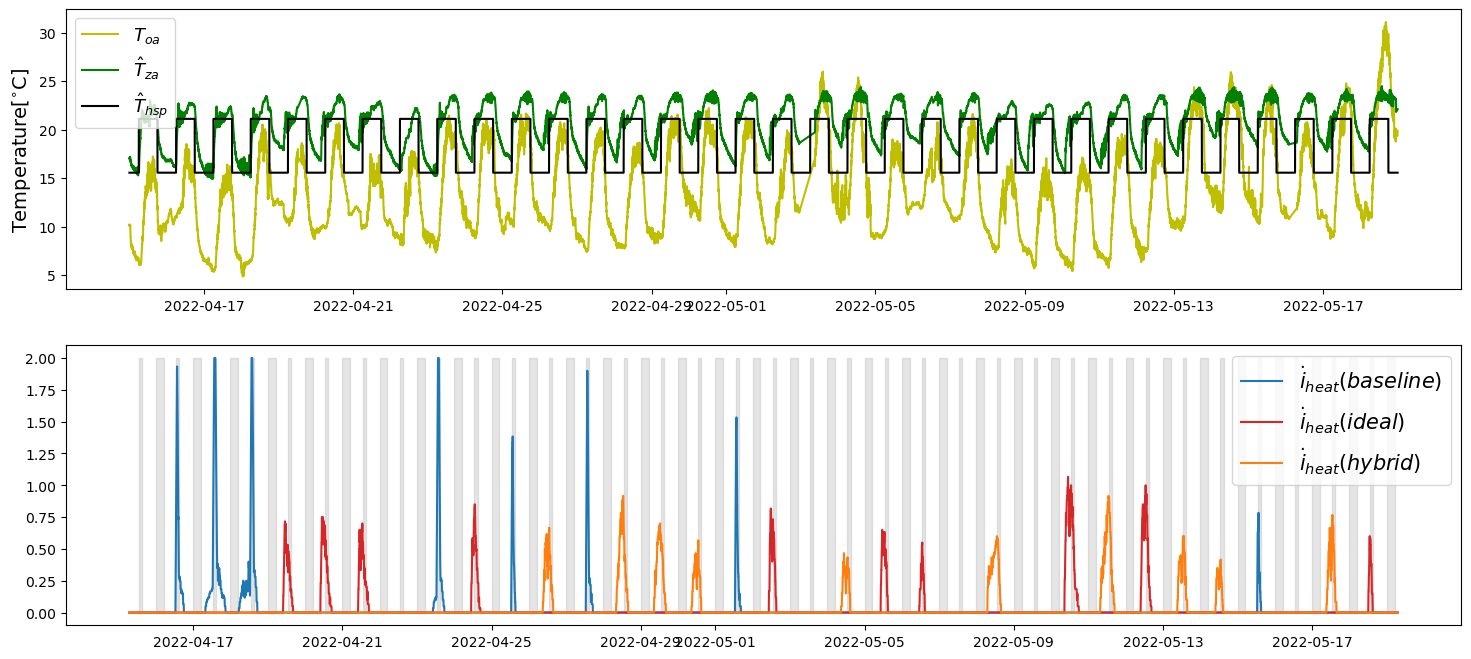

In [16]:
import copy
sdf=copy.deepcopy(df)
sdf['time']=pd.DatetimeIndex(sdf['time'],tz=tz)
sdf=sdf.set_index("time")
fig, ax=plt.subplots(nrows=2,ncols=1,figsize=(18,8))
ax[0].plot(sdf.index.values,sdf['T_oa_1'].to_numpy(),label=r"$T_{oa}$",color='y')
ax[0].plot(sdf.index.values,sdf['T_za_1'],label=r"$\hat{T}_{za}$",color='g')
ax[0].plot(sdf.index.values,sdf['Thsp'],label=r"$\hat{T}_{hsp}$",color='k')
ax[0].xaxis_date(tz=tz)
ax[0].legend(fontsize=13)
ax[0].set_ylabel("Temperature[$^{\circ}$C]",fontsize=14)
ax[1].plot(sdf.index.values,sdf['ma_i_heat_1'].to_numpy()*sdf['baseline'].to_numpy(),label=r"$\dot{i}_{heat}(baseline)$",color='tab:blue')
ax[1].plot(sdf.index.values,sdf['ma_i_heat_1'].to_numpy()*sdf['mpc_ideal'].to_numpy(),label=r"$\dot{i}_{heat}(ideal)$",color='tab:red')
ax[1].plot(sdf.index.values,sdf['ma_i_heat_1'].to_numpy()*sdf['mpc_hybrid'].to_numpy(),label=r"$\dot{i}_{heat}(hybrid)$",color='tab:orange')
#ax[1].plot(sdf.index.values,sdf['i_ma_baseline'].to_numpy(),label=r"$\dot{i}_{heat}(baseline)$",color='tab:blue')
#ax[1].plot(sdf.index.values,sdf['i_ma_mpc_hybrid'].to_numpy(),label=r"$\dot{i}_{heat}(hybrid)$",color='tab:orange')
ax[1].fill_between(sdf.index.values,0,np.max(sdf['ma_i_heat_1'].to_numpy()),where=sdf['peak'].to_numpy(),alpha=0.2,color='grey')
ax[1].legend(fontsize=15)

# Data processing for peak analysis

Highlight and redlines are the peak during the analysis period. Each values are printed at the end.

max highlighted
baseline: 2.15010233995
ideal: 1.4114448729183333
Hybrid: 1.2903180538649999


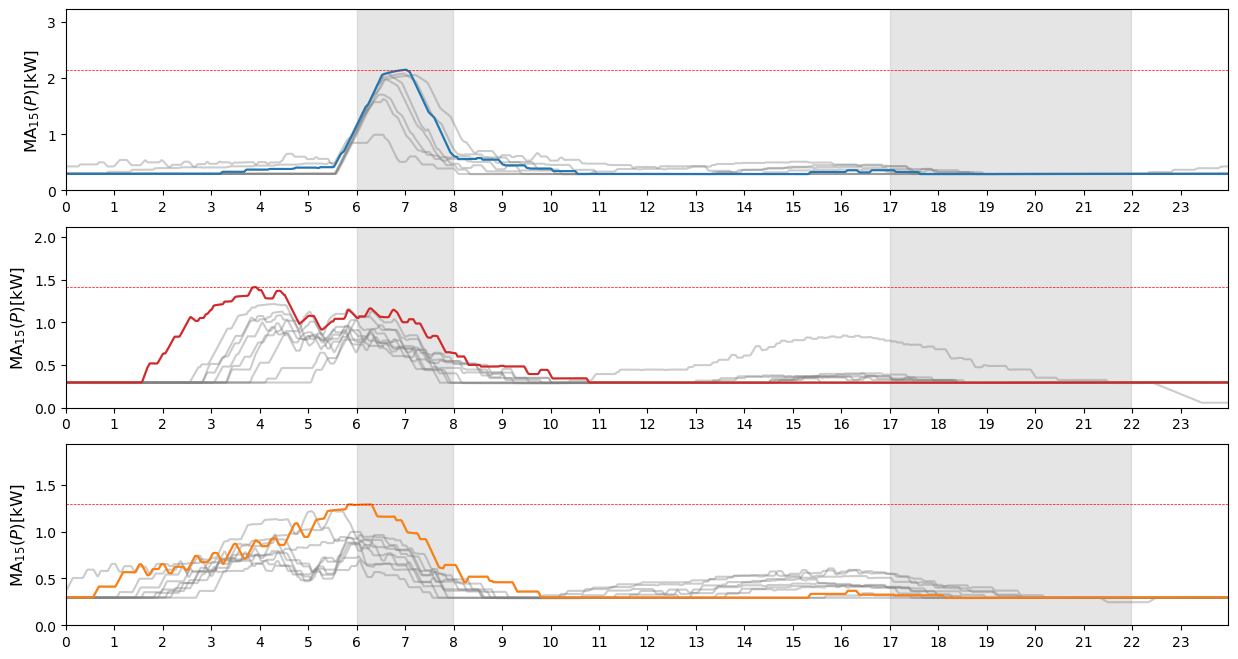

In [17]:
import copy
highlight="max" # "max" or "avg"
sdf=copy.deepcopy(df)
n_data=int(60*24) #60*12
n_select=int(60*24)
sdf['time']=pd.DatetimeIndex(sdf['time'],tz="US/Pacific")
sdf=sdf.set_index("time")
iisdf=sdf[sdf['mday']==baseline_days[0]]
target="ma_P_hp_1"#"i_ma_heat" # P_hp_ma, ma_P_all_0

x_grid=np.arange(n_data)
y_grid=np.zeros_like(x_grid)

fig,ax=plt.subplots(nrows=3,ncols=1,figsize=(15,8))

for  i,i_day in enumerate(baseline_days):
    isdf=sdf[sdf['mday']==i_day]
    if i==0:
        i_ma_avg=y_grid*0.0
        temp=isdf[f'{target}'].to_numpy()[:n_select]
        i_ma_max=y_grid*0.0
        i_ma_max[:temp.shape[0]]=temp
        #i_ma_avg=np.zeros_like(isdf[f'{target}'].to_numpy()[:n_data])
        #i_ma_max=isdf[f'{target}'].to_numpy()[:n_data]
        max_val=np.max(i_ma_max)
    temp=isdf[f'{target}'].to_numpy()[:n_select]
    y_grid_temp=y_grid*0.0
    y_grid_temp[:(temp.shape[0])]=temp
    ax[0].plot(x_grid,y_grid_temp,alpha=0.4,color="gray")
    #temp=isdf[f'{target}'].to_numpy()[:n_data]
    i_ma_avg[:(temp.shape[0])]=i_ma_avg[:(temp.shape[0])]+temp
    max_val_temp=np.max(temp) #np.max(isdf[f'{target}'].to_numpy()[:n_data])
    if max_val_temp>max_val:
        i_ma_max=y_grid*0.0
        i_ma_max[:temp.shape[0]]=temp
        max_val=max_val_temp    
i_ma_avg=i_ma_avg/baseline_days.shape[0]
i_ma_avg_baseline=i_ma_avg
i_ma_max_baseline=i_ma_max

if highlight=="max":
    print('max highlighted')
    ax[0].plot(x_grid,i_ma_max_baseline,color='tab:blue')
    #print(i_ma_max)
    ax[0].axhline(y=max_val, color='r', linestyle='dashed',linewidth=0.5)
    print(f'baseline: {max_val}')
else:
    print("average highlighted")
    ax[0].plot(x_grid,i_ma_avg,color='tab:blue')

ax[0].fill_between(np.arange(iisdf.shape[0]),0,np.max(sdf[f'{target}'].to_numpy()*1.5),where=iisdf['peak'].to_numpy(),alpha=0.2,color='grey')
ax[0].set_xticks(np.arange(24)*60)
ax[0].set_xticklabels((np.arange(0,(24))).astype('int'))
ax[0].set_ylim(0,np.max(i_ma_max)*1.5)
ax[0].margins(x=0)
if highlight=="max":
    ax[0].set_ylabel(r"MA$_{15}(P)$[kW]",fontsize=12)


max_val=0
for i,i_day in enumerate(mpc_ideal_days):
    #print(i)
    isdf=sdf[sdf['mday']==i_day]
    if i==0:
        i_ma_avg=y_grid*0.0
        temp=isdf[f'{target}'].to_numpy()[:n_select]
        i_ma_max=y_grid*0.0
        i_ma_max[:temp.shape[0]]=temp
    
    temp=isdf[f'{target}'].to_numpy()[:n_select]
    y_grid_temp=y_grid*0.0
    y_grid_temp[:temp.shape[0]]=temp
    
    ax[1].plot(x_grid,y_grid_temp,alpha=0.4,color="gray")
    i_ma_avg[:(temp.shape[0])]=i_ma_avg[:(temp.shape[0])]+temp
    max_val_temp=np.max(temp) #np.max(isdf[f'{target}'].to_numpy()[:n_data])
    if max_val_temp>max_val:
        i_ma_max=y_grid*0.0
        i_ma_max[:temp.shape[0]]=temp
        max_val=max_val_temp    

i_ma_avg=i_ma_avg/mpc_ideal_days.shape[0]
i_ma_avg_mpc_ideal=i_ma_avg
i_ma_max_mpc_ideal=i_ma_max


if highlight=="max":
    ax[1].plot(x_grid,i_ma_max_mpc_ideal,color='tab:red')
    ax[1].axhline(y=max_val, color='r', linestyle='dashed',linewidth=0.5)
    print(f'ideal: {max_val}')
else:
    ax[1].plot(x_grid,i_ma_avg_mpc_ideal,label=r"$mean_i_{heat}(ideal)$",color='tab:red')
ax[1].fill_between(np.arange(iisdf.shape[0]),0,np.max(sdf[f'{target}'].to_numpy()*1.5),where=iisdf['peak'].to_numpy(),alpha=0.2,color='grey')    
ax[1].set_xticks(np.arange(24)*60)
ax[1].set_xticklabels((np.arange(0,(24))).astype('int'))
ax[1].set_ylim(0,np.max(i_ma_max)*1.5)


ax[1].margins(x=0)
if highlight=="max":
    ax[1].set_ylabel(r"MA$_{15}(P)$[kW]",fontsize=12)


max_val=0
for i,i_day in enumerate(mpc_hybrid_days):
    isdf=sdf[sdf['mday']==i_day]
    if i==0:
        i_ma_avg=y_grid*0.0
        temp=isdf[f'{target}'].to_numpy()[:n_select]
        i_ma_max=y_grid*0.0
        i_ma_max[:temp.shape[0]]=temp
    
    temp=isdf[f'{target}'].to_numpy()[:n_select]
    b=y_grid*0.0
    y_grid_temp[:temp.shape[0]]=temp
    
    ax[2].plot(x_grid,y_grid_temp,alpha=0.4,color="gray")
    i_ma_avg[:(temp.shape[0])]=i_ma_avg[:(temp.shape[0])]+temp
    max_val_temp=np.max(temp) #np.max(isdf[f'{target}'].to_numpy()[:n_data])
    if max_val_temp>max_val:
        i_ma_max=y_grid*0.0
        i_ma_max[:temp.shape[0]]=temp
        max_val=max_val_temp    

i_ma_avg=i_ma_avg/mpc_hybrid_days.shape[0]
i_ma_avg_mpc_hybrid=i_ma_avg
i_ma_max_mpc_hybrid=i_ma_max


if highlight=="max":
    ax[2].plot(x_grid,i_ma_max_mpc_hybrid,color='tab:orange')
    ax[2].axhline(y=max_val, color='r', linestyle='dashed',linewidth=0.5)
    print(f'Hybrid: {max_val}')
    
else:
    ax[2].plot(x_grid,i_ma_avg_mpc_hybrid,label=r"$mean_i_{heat}(ideal)$",color='tab:orange')
ax[2].fill_between(np.arange(iisdf.shape[0]),0,np.max(sdf[f'{target}'].to_numpy()*1.5),where=iisdf['peak'].to_numpy(),alpha=0.2,color='grey')    
ax[2].set_xticks(np.arange(24)*60)
ax[2].set_xticklabels((np.arange(0,(24))).astype('int'))
ax[2].set_ylim(0,np.max(i_ma_max_mpc_hybrid)*1.5)
ax[2].margins(x=0)
if highlight=="max":
    ax[2].set_ylabel(r"MA$_{15}(P)$[kW]",fontsize=12)



# Temperature profiles

In [18]:
# to F
df['ma_T_za_1_F']=(df['ma_T_za_1'].to_numpy()*1.8)+32

In [19]:
df['ThspF']=(df['Thsp'].to_numpy()*1.8)+32

average highlighted


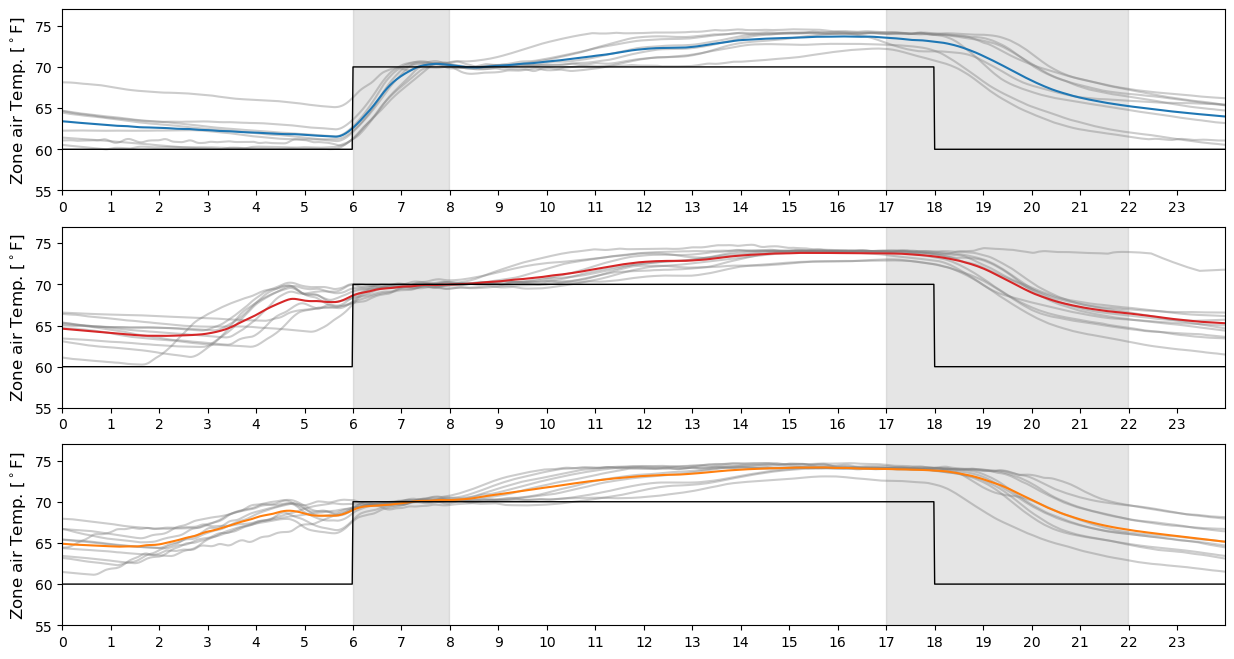

In [20]:
import copy
highlight="avg" # "max" or "avg"
sdf=copy.deepcopy(df)
n_data=int(60*24) #60*12
n_select=int(60*24)
sdf['time']=pd.DatetimeIndex(sdf['time'],tz="US/Pacific")
sdf=sdf.set_index("time")
iisdf=sdf[sdf['mday']==baseline_days[0]]
target="ma_T_za_1_F"#"i_ma_heat" # P_hp_ma, ma_P_all_0
ThspF=iisdf['ThspF'].to_numpy()

x_grid=np.arange(n_data)
y_grid=np.zeros_like(x_grid)

fig,ax=plt.subplots(nrows=3,ncols=1,figsize=(15,8))

for  i,i_day in enumerate(baseline_days):
    isdf=sdf[sdf['mday']==i_day]
    if i==0:
        i_ma_avg=y_grid*0.0
        temp=isdf[f'{target}'].to_numpy()[:n_select]
        i_ma_max=y_grid*0.0
        i_ma_max[:temp.shape[0]]=temp
        #i_ma_avg=np.zeros_like(isdf[f'{target}'].to_numpy()[:n_data])
        #i_ma_max=isdf[f'{target}'].to_numpy()[:n_data]
        max_val=np.max(i_ma_max)
    temp=isdf[f'{target}'].to_numpy()[:n_select]
    y_grid_temp=y_grid*0.0
    y_grid_temp[:(temp.shape[0])]=temp
    ax[0].plot(x_grid,y_grid_temp,alpha=0.4,color="gray")
    #temp=isdf[f'{target}'].to_numpy()[:n_data]
    i_ma_avg[:(temp.shape[0])]=i_ma_avg[:(temp.shape[0])]+temp
    max_val_temp=np.max(temp) #np.max(isdf[f'{target}'].to_numpy()[:n_data])
    if max_val_temp>max_val:
        i_ma_max=y_grid*0.0
        i_ma_max[:temp.shape[0]]=temp
        max_val=max_val_temp    
i_ma_avg=i_ma_avg/baseline_days.shape[0]
i_ma_avg_baseline=i_ma_avg
i_ma_max_baseline=i_ma_max
if highlight=="max":
    print('max highlighted')
    ax[0].plot(x_grid,i_ma_max_baseline,color='tab:blue')
    
    #print(i_ma_max)
    ax[0].axhline(y=max_val, color='r', linestyle='dashed',linewidth=0.5)
    print(f'baseline: {max_val}')
else:
    print("average highlighted")
    ax[0].plot(x_grid,i_ma_avg,color='tab:blue')
ax[0].plot(x_grid,ThspF,color='black',linewidth=1.0)
ax[0].fill_between(np.arange(iisdf.shape[0]),0,np.max(sdf[f'{target}'].to_numpy()*1.2),where=iisdf['peak'].to_numpy(),alpha=0.2,color='grey')
ax[0].set_xticks(np.arange(24)*60)
ax[0].set_xticklabels((np.arange(0,(24))).astype('int'))
ax[0].set_ylim(55,77)
ax[0].margins(x=0)
if highlight=="max":
    ax[0].set_ylabel(r"MA$_{15}(P)$[kW]",fontsize=12)
else:
    ax[0].set_ylabel(r"Zone air Temp. [$^\circ$F]",fontsize=12)

max_val=0
for i,i_day in enumerate(mpc_ideal_days):
    #print(i)
    isdf=sdf[sdf['mday']==i_day]
    if i==0:
        i_ma_avg=y_grid*0.0
        temp=isdf[f'{target}'].to_numpy()[:n_select]
        i_ma_max=y_grid*0.0
        i_ma_max[:temp.shape[0]]=temp
    
    temp=isdf[f'{target}'].to_numpy()[:n_select]
    y_grid_temp=y_grid*0.0
    y_grid_temp[:temp.shape[0]]=temp
    
    ax[1].plot(x_grid,y_grid_temp,alpha=0.4,color="gray")
    i_ma_avg[:(temp.shape[0])]=i_ma_avg[:(temp.shape[0])]+temp
    max_val_temp=np.max(temp) #np.max(isdf[f'{target}'].to_numpy()[:n_data])
    if max_val_temp>max_val:
        i_ma_max=y_grid*0.0
        i_ma_max[:temp.shape[0]]=temp
        max_val=max_val_temp    

i_ma_avg=i_ma_avg/mpc_ideal_days.shape[0]
i_ma_avg_mpc_ideal=i_ma_avg
i_ma_max_mpc_ideal=i_ma_max


if highlight=="max":
    ax[1].plot(x_grid,i_ma_max_mpc_ideal,color='tab:red')
    ax[1].axhline(y=max_val, color='r', linestyle='dashed',linewidth=0.5)
    print(f'ideal: {max_val}')
else:
    ax[1].plot(x_grid,i_ma_avg_mpc_ideal,label=r"$mean_i_{heat}(ideal)$",color='tab:red')
ax[1].fill_between(np.arange(iisdf.shape[0]),0,np.max(sdf[f'{target}'].to_numpy()*1.5),where=iisdf['peak'].to_numpy(),alpha=0.2,color='grey')    
ax[1].set_xticks(np.arange(24)*60)
ax[1].set_xticklabels((np.arange(0,(24))).astype('int'))
ax[1].set_ylim(55,77)
ax[1].plot(x_grid,ThspF,color='black',linewidth=1.0)


ax[1].margins(x=0)
if highlight=="max":
    ax[1].set_ylabel(r"MA$_{15}(P)$[kW]",fontsize=12)
else:
    ax[1].set_ylabel(r"Zone air Temp. [$^\circ$F]",fontsize=12)

max_val=0
for i,i_day in enumerate(mpc_hybrid_days):
    isdf=sdf[sdf['mday']==i_day]
    if i==0:
        i_ma_avg=y_grid*0.0
        temp=isdf[f'{target}'].to_numpy()[:n_select]
        i_ma_max=y_grid*0.0
        i_ma_max[:temp.shape[0]]=temp
    
    temp=isdf[f'{target}'].to_numpy()[:n_select]
    b=y_grid*0.0
    y_grid_temp[:temp.shape[0]]=temp
    
    ax[2].plot(x_grid,y_grid_temp,alpha=0.4,color="gray")
    i_ma_avg[:(temp.shape[0])]=i_ma_avg[:(temp.shape[0])]+temp
    max_val_temp=np.max(temp) #np.max(isdf[f'{target}'].to_numpy()[:n_data])
    if max_val_temp>max_val:
        i_ma_max=y_grid*0.0
        i_ma_max[:temp.shape[0]]=temp
        max_val=max_val_temp    

i_ma_avg=i_ma_avg/mpc_hybrid_days.shape[0]
i_ma_avg_mpc_hybrid=i_ma_avg
i_ma_max_mpc_hybrid=i_ma_max


if highlight=="max":
    ax[2].plot(x_grid,i_ma_max_mpc_hybrid,color='tab:orange')
    ax[2].axhline(y=max_val, color='r', linestyle='dashed',linewidth=0.5)
    print(f'Hybrid: {max_val}')
    
else:
    ax[2].plot(x_grid,i_ma_avg_mpc_hybrid,label=r"$mean_i_{heat}(ideal)$",color='tab:orange')
ax[2].fill_between(np.arange(iisdf.shape[0]),0,np.max(sdf[f'{target}'].to_numpy()*1.5),where=iisdf['peak'].to_numpy(),alpha=0.2,color='grey')    
ax[2].set_xticks(np.arange(24)*60)
ax[2].set_xticklabels((np.arange(0,(24))).astype('int'))
ax[2].set_ylim(55,77)
ax[2].margins(x=0)
ax[2].plot(x_grid,ThspF,color='black',linewidth=1.0)
if highlight=="max":
    ax[2].set_ylabel(r"MA$_{15}(P)$[kW]",fontsize=12)
else:
    ax[2].set_ylabel(r"Zone air Temp. [$^\circ$F]",fontsize=12)
#plt.savefig("out.jpg",dpi=300)

# load shifting . Moving average 60

In [21]:
dff=copy.deepcopy(df)
rolling_mins=60
dff=calculate_ma(df_=dff,rolling_mins=rolling_mins,col_name="i_heat_1")
dff=calculate_ma(df_=dff,rolling_mins=rolling_mins,col_name="P_hp_1")
dff=calculate_ma(df_=dff,rolling_mins=rolling_mins,col_name="P_all_1")
dff=calculate_ma(df_=dff,rolling_mins=rolling_mins,col_name="T_za_1")


In [22]:
import copy
highlight="max" # "max" or "avg"
sdf=copy.deepcopy(dff)
n_data=int(60*24) #60*12
n_select=int(60*24)
sdf['time']=pd.DatetimeIndex(sdf['time'],tz="US/Pacific")
sdf=sdf.set_index("time")
iisdf=sdf[sdf['mday']==baseline_days[0]]
target="ma_P_hp_1"#"i_ma_heat" # P_hp_ma, ma_P_all_0

x_grid=np.arange(n_data)
y_grid=np.zeros_like(x_grid)


for  i,i_day in enumerate(baseline_days):
    isdf=sdf[sdf['mday']==i_day]
    if i==0:
        i_ma_avg=y_grid*0.0
        temp=isdf[f'{target}'].to_numpy()[:n_select]
        i_ma_max=y_grid*0.0
        i_ma_max[:temp.shape[0]]=temp
        #i_ma_avg=np.zeros_like(isdf[f'{target}'].to_numpy()[:n_data])
        #i_ma_max=isdf[f'{target}'].to_numpy()[:n_data]
        max_val=np.max(i_ma_max)
    temp=isdf[f'{target}'].to_numpy()[:n_select]
    y_grid_temp=y_grid*0.0
    y_grid_temp[:(temp.shape[0])]=temp
    #temp=isdf[f'{target}'].to_numpy()[:n_data]
    i_ma_avg[:(temp.shape[0])]=i_ma_avg[:(temp.shape[0])]+temp
    max_val_temp=np.max(temp) #np.max(isdf[f'{target}'].to_numpy()[:n_data])
    if max_val_temp>max_val:
        i_ma_max=y_grid*0.0
        i_ma_max[:temp.shape[0]]=temp
        max_val=max_val_temp    
i_ma_avg=i_ma_avg/baseline_days.shape[0]
i_ma_avg_baseline=i_ma_avg
i_ma_max_baseline=i_ma_max



max_val=0
for i,i_day in enumerate(mpc_ideal_days):
    #print(i)
    isdf=sdf[sdf['mday']==i_day]
    if i==0:
        i_ma_avg=y_grid*0.0
        temp=isdf[f'{target}'].to_numpy()[:n_select]
        i_ma_max=y_grid*0.0
        i_ma_max[:temp.shape[0]]=temp
    
    temp=isdf[f'{target}'].to_numpy()[:n_select]
    y_grid_temp=y_grid*0.0
    y_grid_temp[:temp.shape[0]]=temp
    
    
    i_ma_avg[:(temp.shape[0])]=i_ma_avg[:(temp.shape[0])]+temp
    max_val_temp=np.max(temp) #np.max(isdf[f'{target}'].to_numpy()[:n_data])
    if max_val_temp>max_val:
        i_ma_max=y_grid*0.0
        i_ma_max[:temp.shape[0]]=temp
        max_val=max_val_temp    

i_ma_avg=i_ma_avg/mpc_ideal_days.shape[0]
i_ma_avg_mpc_ideal=i_ma_avg
i_ma_max_mpc_ideal=i_ma_max



max_val=0
for i,i_day in enumerate(mpc_hybrid_days):
    isdf=sdf[sdf['mday']==i_day]
    if i==0:
        i_ma_avg=y_grid*0.0
        temp=isdf[f'{target}'].to_numpy()[:n_select]
        i_ma_max=y_grid*0.0
        i_ma_max[:temp.shape[0]]=temp
    
    temp=isdf[f'{target}'].to_numpy()[:n_select]
    b=y_grid*0.0
    y_grid_temp[:temp.shape[0]]=temp
    
    i_ma_avg[:(temp.shape[0])]=i_ma_avg[:(temp.shape[0])]+temp
    max_val_temp=np.max(temp) #np.max(isdf[f'{target}'].to_numpy()[:n_data])
    if max_val_temp>max_val:
        i_ma_max=y_grid*0.0
        i_ma_max[:temp.shape[0]]=temp
        max_val=max_val_temp    

i_ma_avg=i_ma_avg/mpc_hybrid_days.shape[0]
i_ma_avg_mpc_hybrid=i_ma_avg
i_ma_max_mpc_hybrid=i_ma_max



(0.0, 2.0)

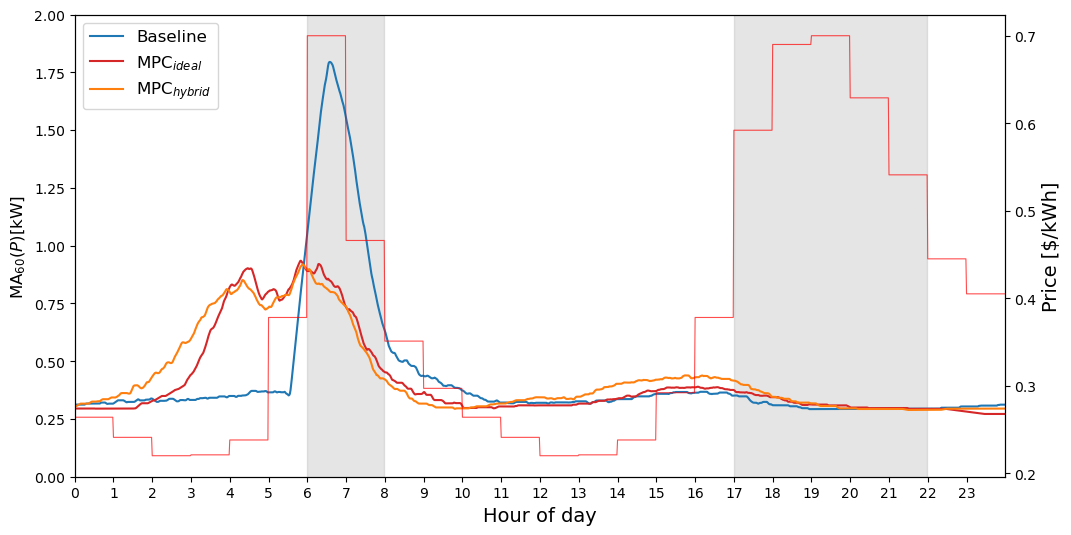

In [23]:
iisdf=sdf[sdf['mday']==baseline_days[0]]


fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(12,6))

ax2 = ax.twinx()
ax.plot(i_ma_avg_baseline,label=r"Baseline",color="tab:blue")
ax.plot(i_ma_avg_mpc_ideal,label=r"MPC$_{ideal}$",color="tab:red")
ax.plot(i_ma_avg_mpc_hybrid,label=r"MPC$_{hybrid}$",color="tab:orange")

ax.fill_between(np.arange(iisdf.shape[0]),-1,np.max(sdf[f'{target}'].to_numpy())*1.5,where=iisdf['peak'].to_numpy(),alpha=0.2,color='grey')    
ax.set_xticks(np.arange(24)*60)
ax.set_xticklabels((np.arange(0,(24))).astype('int'))
ax.set_xlabel("Hour of day",fontsize=14)
#ax.set_ylabel(f"{target}",fontsize=14)
ax.set_ylabel(r"",fontsize=14)

ax2.plot(iisdf['price'].to_numpy(),label=r'Price',color="red",alpha=0.7,linewidth=0.8)
#ax.fill_between(np.arange(isdf.shape[0]),-1,np.max(sdf['i_ma_heat'].to_numpy())*1.5,where=isdf['peak'].to_numpy(),alpha=0.2,color='grey')    
#ax[0].set_xticks(np.arange(24)*60)
#ax[0].set_xticklabels((np.arange(0,(24))).astype('int'))
#ax[0].set_xlabel("Hour of day",fontsize=14)
ax.set_ylabel(r"MA$_{60}(P)$[kW]",fontsize=12)
ax2.set_ylabel("Price [$/kWh]",fontsize=14)
ax.legend(fontsize=12,loc="upper left")
ax.margins(x=0)
ax.set_ylim((0,2.0))
#fig.savefig("price.png",dpi=300,bbox_inches='tight')


In [24]:
# calculate 
peak_start_hour=6
peak_end_hour=8
heating_end_time=24

P_bs_peak=np.mean(i_ma_avg_baseline[60*peak_start_hour:60*peak_end_hour])
P_mpc_peak=np.mean(i_ma_avg_mpc_ideal[60*peak_start_hour:60*peak_end_hour])
P_hybrid_peak=np.mean(i_ma_avg_mpc_hybrid[60*peak_start_hour:60*peak_end_hour])
P_bs_npeak=np.mean(np.concatenate([i_ma_avg_baseline[:60*peak_start_hour],i_ma_avg_baseline[60*peak_end_hour:60*heating_end_time]]))
P_mpc_npeak=np.mean(np.concatenate([i_ma_avg_mpc_ideal[:60*peak_start_hour],i_ma_avg_mpc_ideal[60*peak_end_hour:60*heating_end_time]]))
P_hybrid_npeak=np.mean(np.concatenate([i_ma_avg_mpc_hybrid[:60*peak_start_hour],i_ma_avg_mpc_hybrid[60*peak_end_hour:60*heating_end_time]]))

print(f'Peak shed is MPC(ideal): {((P_bs_peak-P_mpc_peak)/(P_bs_peak)*100).round(2)}% ({((P_bs_peak-P_mpc_peak)*(peak_end_hour-peak_start_hour)).round(2)})kWh reduction, MPC(hybrid): {((P_bs_peak-P_hybrid_peak)/(P_bs_peak)*100).round(2)}% ({((P_bs_peak-P_hybrid_peak)*(peak_end_hour-peak_start_hour)).round(2)})kWh reduction')
print(f'Load take is MPC(ideal): {((P_mpc_npeak-P_bs_npeak)/(P_bs_npeak)*100).round(2)}% ({((P_mpc_npeak-P_bs_npeak)*(peak_start_hour+(heating_end_time-peak_end_hour))).round(2)})kWh increase, MPC(hybrid): {((P_hybrid_npeak-P_bs_npeak)/(P_bs_npeak)*100).round(2)}%  ({((P_hybrid_npeak-P_bs_npeak)*(peak_start_hour+(heating_end_time-peak_end_hour))).round(2)})kWh increase')

# due to the limited data period, the comparison is not ideally fair. But, still good enough to see the effect.

Peak shed is MPC(ideal): 44.91% (1.18)kWh reduction, MPC(hybrid): 47.93% (1.26)kWh reduction
Load take is MPC(ideal): 11.84% (0.9)kWh increase, MPC(hybrid): 18.59%  (1.41)kWh increase


# cost anaylsis



In [25]:

df['elec']=df['P_hp_1'].to_numpy()/60*df['price'].to_numpy() # Power x cost

df['hour_int']=df['hour'].to_numpy().astype('int')


#day_adjust=(df['hour_int']>=18).to_numpy()*1 # not used.
group_id=df['mday'].to_numpy()#+day_adjust
df['group_id']=group_id



In [26]:

df2=copy.deepcopy(df[df.mday.isin(all_days)])

#df_summary=copy.deepcopy(df2[['day','elec']].groupby(['day']).mean().reset_index()) # |(df2['hour_int']>=20)
df_summary_oa=copy.deepcopy(df2[(df2['hour_int']<=10)][['group_id','T_oa_1']].groupby(['group_id']).mean().reset_index())
df_summary=copy.deepcopy(df2[(df2['hour_int']<=10)][['group_id','elec']].groupby(['group_id']).mean().reset_index())
df_summary=pd.merge(df_summary,df_summary_oa,how='left',on='group_id')

df_summary['type']="none"
df_summary['type'][df_summary.group_id.isin(baseline_days)]='baseline'
df_summary['type'][df_summary.group_id.isin(mpc_ideal_days)]='mpc_ideal'
df_summary['type'][df_summary.group_id.isin(mpc_hybrid_days)]='mpc_hybrid'
df_summary['dollar']=df_summary['elec'].to_numpy()*12*60
df_summary=df_summary[df_summary['type']!="none"]

#df_summary=df_summary[df_summary['group_id']!=22]


/var/folders/xh/_myqhrvd2zd_ct7zmrkxsd980000gn/T/ipykernel_8374/4107432504.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_summary['type'][df_summary.group_id.isin(baseline_days)]='baseline'
/var/folders/xh/_myqhrvd2zd_ct7zmrkxsd980000gn/T/ipykernel_8374/4107432504.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_summary['type'][df_summary.group_id.isin(mpc_ideal_days)]='mpc_ideal'
/var/folders/xh/_myqhrvd2zd_ct7zmrkxsd980000gn/T/ipykernel_8374/4107432504.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

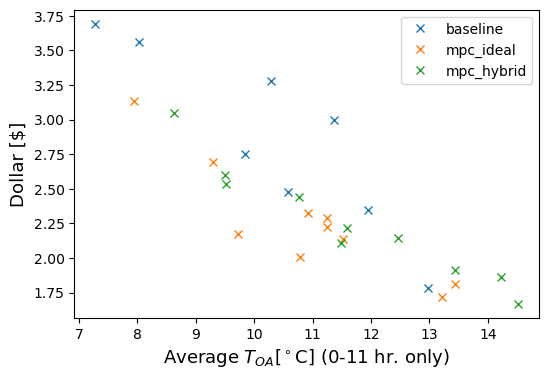

In [27]:

plt.figure(figsize=(6,4))
plt.plot(df_summary['T_oa_1'][df_summary['type']=='baseline'],df_summary['dollar'][df_summary['type']=='baseline'],'x',label='baseline')
plt.plot(df_summary['T_oa_1'][df_summary['type']=='mpc_ideal'],df_summary['dollar'][df_summary['type']=='mpc_ideal'],'x',label='mpc_ideal')
plt.plot(df_summary['T_oa_1'][df_summary['type']=='mpc_hybrid'],df_summary['dollar'][df_summary['type']=='mpc_hybrid'],'x',label='mpc_hybrid')
plt.xlabel(r"Average $T_{OA}$[$^\circ$C] (0-11 hr. only)",fontsize=13)
plt.ylabel("Dollar [$]",fontsize=13)
plt.legend()




In [28]:

df_summary[(df_summary['T_oa_1']>=7.5)&(df_summary['T_oa_1']<=13.0) ].groupby(['type']).mean().reset_index()



,type,group_id,elec,T_oa_1,dollar
0,baseline,446.428571,0.003809,10.720827,2.742587
1,mpc_hybrid,476.000000,0.003392,10.563480,2.442115
2,mpc_ideal,464.125000,0.003296,10.337132,2.372919


In [29]:
# group_id: day

In [30]:
df_summary

,group_id,elec,T_oa_1,type,dollar
0,416,0.004163,11.362963,baseline,2.997126
1,417,0.005129,7.281734,baseline,3.692960
2,418,0.004948,8.036111,baseline,3.562477
3,419,0.002966,11.524158,mpc_ideal,2.135878
4,420,0.003229,10.927020,mpc_ideal,2.325060
5,421,0.003085,11.248569,mpc_ideal,2.221068
6,423,0.004552,10.292845,baseline,3.277726
7,424,0.003178,11.247306,mpc_ideal,2.288020
8,425,0.003258,11.955303,baseline,2.345701
9,426,0.002930,11.483081,mpc_hybrid,2.109833
